In [1]:
# Dependency libraries
from time import time

import torch
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from matplotlib import colors

# Custom libraries
import datasets

from plot_utils import plt_style

plt_style()
%matplotlib inline

### Load spiral dataset

In [2]:
X, Y = datasets.data_spiral(10000, 50)

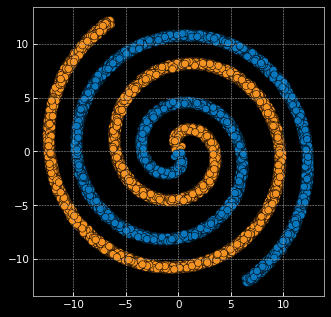

In [3]:
plt.figure(figsize=(5, 5), dpi=75)
colormap = colors.ListedColormap(["#f59322", "#e8eaeb", "#0877bd"])
x_min, x_max = -6, 6  # grid x bounds
y_min, y_max = -6, 6  # grid y bounds

plt.scatter(X[:,0],X[:,1],edgecolors='k', s=50, c=Y, cmap=colormap);

In [4]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)

### Custom Dataset Loader

In [5]:
class TrainingDatasetLoader(Dataset):
    def __init__(self, x, y):
        self.points = torch.Tensor(x)
        self.labels = torch.Tensor(y).type(torch.LongTensor)
        self.len = len(self.labels)

    def __getitem__(self, idx):

        point = self.points[idx]
        label = self.labels[idx]

        return point, label
    
    def __len__(self):
        return self.len
    
class InferenceDatasetLoader(Dataset):
    def __init__(self, x):
        self.points = torch.Tensor(x)
        self.len = len(self.points)

    def __getitem__(self, idx):

        point = self.points[idx]
        return point
    
    def __len__(self):
        return self.len

### Model Definition

In [6]:
class fcModel(nn.Module):
    def __init__(self, input_shape, output_shape):
        """Model class constructor"""
        super(fcModel, self).__init__()
        
        self.linear = nn.Linear(2, 8)
        self.fully_connected_stack = nn.Sequential(
            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
            nn.ReLU(),            
            nn.Linear(8, 2),
        )
        
    def forward(self, x):
        
        x = self.linear(x)
        logits = self.fully_connected_stack(x)        
        return logits

### Trainer class

In [7]:
class FullyConnected:    
    
    def __init__(self, epochs = 50):
        self.verbose_frequency = 10
        self.batch_size = 128
        self.epochs = epochs
        self.lr = 0.001
        self.history = {"accuracy":[], "loss":[]}
        self.loss_function = self.get_loss_function()
        self.model = fcModel(2,2)
        
    def get_data(self, x, y, batch_size):
        
        data_iterator = TrainingDatasetLoader(x, y)
        return DataLoader(data_iterator, batch_size=batch_size, shuffle=True)

    def get_data_to_inference(self, x, batch_size):
        
        data_iterator = InferenceDatasetLoader(x)
        return DataLoader(data_iterator, batch_size=batch_size, shuffle=False)
    
    
    def get_loss_function(self):
        """Define Loss function"""
        return nn.CrossEntropyLoss()

    def get_optimizer(self, params):
        """Define gradient descent as the optimizer to minimise the loss"""
        return torch.optim.Adam(params, lr=self.lr)

    def get_history(self):
        """Get training history"""
        
        return self.history
    
    def fit(self, x, y):
        """Train and evaluate model"""
        history = []
        optimizer = self.get_optimizer(self.model.parameters())
        train_dataloader = self.get_data(x, y, self.batch_size)
        print("Training...")
        for epoch in range(1, self.epochs+1):
            
            for batch_idx, (x, y) in enumerate(train_dataloader):
            
                # forward pass
                preds = self.model(x)

                # loss calculation
                loss = self.loss_function(preds, y)

                # backward prop
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        
            
            # perform forward pass to evaluate epoch
            total_loss, total_accuracy = 0, 0
                
            with torch.no_grad():
                for x,y in train_dataloader:
                    preds = self.model(x)

                    # calculate batch loss
                    loss = self.loss_function(preds, y).item()
                    total_loss += loss

                    # calculate batch accuracy
                    accuracy = (preds.argmax(1) == y).type(torch.float).sum().item()
                    total_accuracy += accuracy

            epoch_loss = total_loss/batch_idx
            epoch_accuracy = total_accuracy/len(train_dataloader.dataset)

            # record training history
            self.history["accuracy"].append(epoch_accuracy)
            self.history["loss"].append(epoch_loss)
            
            if epoch % self.verbose_frequency == 0:
                print('Epoch {:d} - Train loss: {:.3f} - Train Accuracy: {:.2f}%'.format(
                                    epoch, 
                                    epoch_loss,
                                    (epoch_accuracy) * 100))

    def eval(self, x, y):
        """Evaluate test set"""
        print("Evaluating...")
        # get testing set
        test_dataloader = self.get_data(x, y, len(x))
        loss, accuracy = 0, 0
        total_preds = []
        with torch.no_grad():
            for x,y in test_dataloader:
                preds = self.model(x)
                total_preds.append(preds.argmax(1).numpy())
                loss += self.loss_function(preds, y).item()
                accuracy += (preds.argmax(1) == y).type(torch.float).sum().item()

        print('Test loss: {:.3f} - Test Accuracy: {:.2f}%'.format(loss/len(test_dataloader), (accuracy/len(test_dataloader.dataset)) * 100))

    def predict(self, x):
        """Define prediction"""
        print("Predicting...")
        # get testing set
        test_dataloader = self.get_data_to_inference(x, len(x))
        with torch.no_grad():
            for x in test_dataloader:
                preds = self.model(x)

        return preds

### Model Training

In [8]:
%%time
fc = FullyConnected(60)
fc.fit(x_train, y_train)

# evaluate on test set
fc.eval(x_test, y_test)

Training...
Epoch 10 - Train loss: 0.571 - Train Accuracy: 60.25%
Epoch 20 - Train loss: 0.142 - Train Accuracy: 98.24%
Epoch 30 - Train loss: 0.036 - Train Accuracy: 99.22%
Epoch 40 - Train loss: 0.016 - Train Accuracy: 99.37%
Epoch 50 - Train loss: 0.008 - Train Accuracy: 99.70%
Epoch 60 - Train loss: 0.005 - Train Accuracy: 99.84%
Evaluating...
Test loss: 0.005 - Test Accuracy: 99.85%
CPU times: user 57.4 s, sys: 8.06 ms, total: 57.5 s
Wall time: 12.3 s


In [9]:
history = fc.get_history()

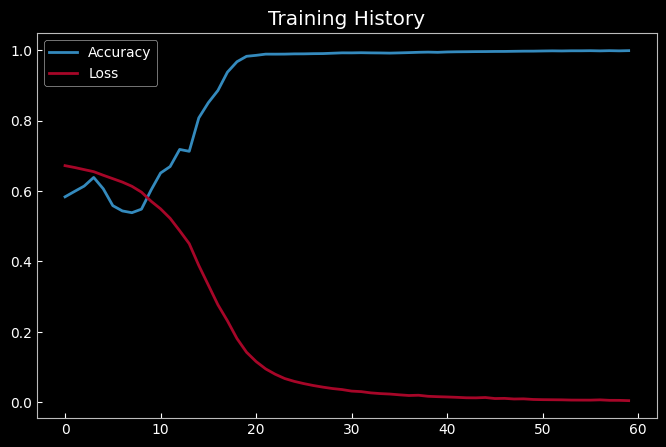

In [10]:
plt.title("Training History")
plt.plot(history["accuracy"])
plt.plot(history["loss"])
plt.grid()
plt.legend(["Accuracy", "Loss"]);

### Inference Runtime

In [14]:
%%time
# inference on test set
x, _, xx, yy = datasets.grid_points()
z_preds = fc.predict(x)
z_preds = np.argmax(z_preds,axis=1)

Predicting...
CPU times: user 161 ms, sys: 0 ns, total: 161 ms
Wall time: 92.9 ms


In [15]:
%%time
# x test prediction
predictions = fc.predict(x_test)

Predicting...
CPU times: user 11.1 ms, sys: 3.78 ms, total: 14.8 ms
Wall time: 13.2 ms


### Plot grid prediction

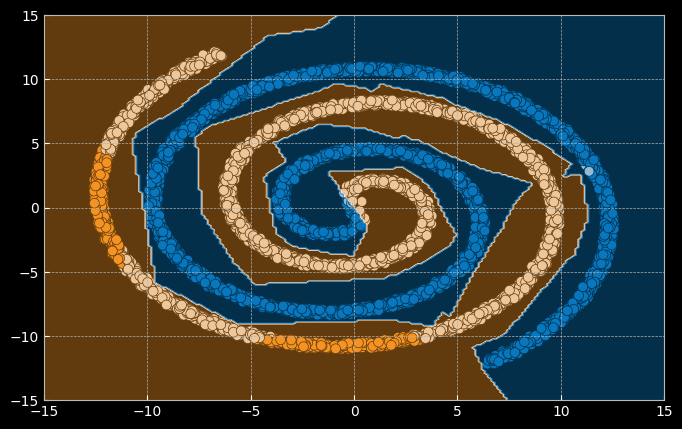

In [16]:
plt.scatter(x_test[:,0], x_test[:,1], c=predictions[:,1], edgecolors='k', s=50, cmap=colormap)
plt.contourf(xx,yy,z_preds.reshape(xx.shape), cmap=colormap, alpha=0.4);